In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys; sys.path.append('../src/')
from model.cmpnts import MLP, SNMLP
from scipy.stats import ortho_group
import matplotlib.pyplot as plt

In [2]:
def nonlinearity(dataset, epsilon=1.): # epsilon can be set to the groundtruth LD manifold's average std.
    X = dataset[:]
    _, s, _ = torch.svd(X - X.mean(0), compute_uv=False)
    return s.max() / s.min(), s.min() / epsilon, s

# Nonlinear Dataset

In [3]:
from dataset.toy import IsometricEmbedding
from model.flow import _RealNVP

In [16]:
in_dim = 2
out_dim = 10

X = torch.randn(100, in_dim)
Y = IsometricEmbedding(X, out_dim=out_dim)

In [17]:
nets = lambda: nn.Sequential(
    nn.Linear(out_dim, 256), nn.ReLU(), 
    nn.Linear(256, 256), nn.ReLU(),
    nn.Linear(256, 256), nn.ReLU(),
    nn.Linear(256, out_dim), nn.Tanh())
nett = lambda: nn.Sequential(
    nn.Linear(out_dim, 256), nn.ReLU(), 
    nn.Linear(256, 256), nn.ReLU(),
    nn.Linear(256, 256), nn.ReLU(),
    nn.Linear(256, out_dim))
masks = torch.as_tensor([
    [0]*(out_dim//2) + [1]*(out_dim//2), 
    [1]*(out_dim//2) + [0]*(out_dim//2)] * 5, dtype=torch.float) # split
flow = _RealNVP(nets, nett, masks)

Y.embed(flow = flow,
        optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4),
        epochs = 300, #100,
        batch_size = 100,
        lam = 100.)

Embedding: 100%|██████████████████████████████| 300/300 [00:20<00:00, 14.86it/s, isometricity=0.113, linearity=0.87]  


In [18]:
nonlinearity(Y[:])

(tensor(4.5805),
 tensor(0.8555),
 tensor([3.9187, 3.1368, 3.0679, 3.0243, 2.6351, 2.4446, 2.1492, 1.8633, 1.6206,
         0.8555]))

# Least Volume

In [34]:
encoder = MLP(out_dim, out_dim, [128]*5) #.cuda()
decoder = MLP(out_dim, out_dim, [128]*5) # SNMLP(out_dim, out_dim, [128]*5) #.cuda()
encoder.train()
decoder.train()

dataset = Y
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i in range(100000):
    for data in dataloader:
        opt.zero_grad()
        z = encoder(data)
        rec_loss = F.mse_loss(decoder(z), data) 
        lasso_loss = torch.norm(z, p=1, dim=-1).mean() # torch.exp(torch.log(z.std(0) + 0.01).mean()) # torch.norm(z.std(0), p=1)
        loss = rec_loss + 0.0001 * lasso_loss
        loss.backward()
        opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, lasso_loss))

Epoch 0: rec = 20.080970764160156, lasso = 0.44628751277923584
Epoch 100: rec = 0.06323938071727753, lasso = 26.05376625061035
Epoch 200: rec = 0.06309932470321655, lasso = 25.399822235107422
Epoch 300: rec = 0.06304215639829636, lasso = 24.640413284301758
Epoch 400: rec = 0.06298110634088516, lasso = 23.970609664916992
Epoch 500: rec = 0.0629228800535202, lasso = 23.357458114624023
Epoch 600: rec = 0.06287184357643127, lasso = 22.701030731201172
Epoch 700: rec = 0.06282902508974075, lasso = 22.004688262939453
Epoch 800: rec = 0.0627933144569397, lasso = 21.27181625366211
Epoch 900: rec = 0.06275783479213715, lasso = 20.500089645385742
Epoch 1000: rec = 0.06272615492343903, lasso = 19.711387634277344
Epoch 1100: rec = 0.0626937597990036, lasso = 19.086395263671875
Epoch 1200: rec = 0.06266561895608902, lasso = 18.504352569580078
Epoch 1300: rec = 0.06264020502567291, lasso = 17.91658592224121
Epoch 1400: rec = 0.0626150518655777, lasso = 17.322593688964844
Epoch 1500: rec = 0.062590748

In [35]:
encoder.eval() 
encoder(data).var(0).sort()

torch.return_types.sort(
values=tensor([3.3663e-08, 4.4459e-06, 5.4626e-06, 1.6865e-04, 2.0443e-04, 2.9141e-04,
        5.7997e-04, 6.1478e-04, 7.9586e-04, 1.8840e-03],
       grad_fn=<SortBackward0>),
indices=tensor([1, 6, 7, 5, 2, 4, 9, 3, 0, 8]))

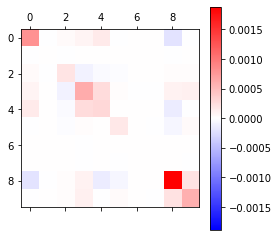

In [36]:
C = encoder(data).T.cov()
plt.matshow(C.detach().cpu().numpy(), cmap='bwr', vmax=C.abs().max(), vmin=-C.abs().max())
plt.colorbar()
plt.show()